# Análisis Encuesta Origen-Destino -  Limpieza de Datos & Cálculo de Indicadores

## Mexico-DF-2017

#### Elaborado por Paula Vásquez-Henríquez, Ariel López, Genaro Cuadros, Exequiel Gaete, Alba Vásquez y Juan Correa

In [ ]:
!pip3 uninstall matplotlib -y

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [ ]:
!git clone https://github.com/zorzalerrante/aves.git aves_git

Cloning into 'aves_git'...
remote: Enumerating objects: 832, done.
remote: Counting objects: 100% (463/463), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 832 (delta 200), reused 435 (delta 183), pack-reused 369
Receiving objects: 100% (832/832), 165.53 MiB | 26.94 MiB/s, done.
Resolving deltas: 100% (323/323), done.
Checking out files: 100% (280/280), done.


In [ ]:
!mamba env update --name base --file aves_git/environment-colab.yml

pkgs/r/linux-64          [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
conda-forge/linux-64     [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
conda-forge/linux-64     [] (00m:00s) 317 KB / ?? (1.02 MB/s)
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
conda-forge/linux-64     [] (00m:00s) 317 KB / ?? (1.02 MB/s)
conda-forge/noarch       [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
conda-forge/linux-64     [] (00m:00s) 317 KB / ?? (1.02 MB/s)
conda-forge/noarch       [] (00m:00s) 145 KB / ?? (481.19 KB/s)
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
conda-forge/linux-64     [] (00m:00s) 317 KB / ?? (1.02 MB/s)
conda-forge/noarch       [] (00m:00s) 145 KB / ?? (481.19 KB/s)
pkgs/main/linux-64       [] (00m:00s) 
pkgs/r/linux-64          [] (00m:00s) 260 KB / ?? (863.82 KB/s)
conda-forge/linux-64

In [ ]:
!pip3 install geopandas
!pip3 install haversine
!pip3 install pandasql
!pip3 install seaborn

     |████████████████████████████████| 1.6 MB 7.9 MB/s 
     |████████████████████████████████| 150 kB 59.5 MB/s 
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26818 sha256=3f884f8364e97a59cf9cf25f11df5050719a0ce957f5ed9182ba8fc48294cadb
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import warnings
import haversine as hs
import shapely
from sklearn.preprocessing import normalize
import datetime
from pandasql import sqldf

In [ ]:
def convert_datatype(df, lista_columnas):
    for column in lista_columnas:
        df[column] = df[column].str.replace(",", ".").astype(float)
    return df

In [ ]:
def imputar_coordenadas_centroide_zat(df, latitud, longitud, zat, shp_id):
    mask = df[latitud].isnull() | df[longitud].isnull()
    ids_latitud_vacia = df[mask].index
    working_df = pd.merge(df, city_shp[[shp_id, 'x_coord', 'y_coord']], left_on=zat, right_on=shp_id, how='left')
    df.loc[ids_latitud_vacia, latitud] = working_df.loc[ids_latitud_vacia, 'y_coord']
    df.loc[ids_latitud_vacia, longitud] = working_df.loc[ids_latitud_vacia, 'x_coord']
    return df

In [ ]:
def mapear_vacios(row, column):
    if pd.isna(row[column])==True:
        return 'Sin información'
    else:
        return row[column]

In [ ]:
def manhattan_distance(a, b):
    return np.abs(a - b).sum()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def decode_column(df, fname, col_name, index_col='id', value_col=None, sep=',', encoding='utf-8'):
    '''
    param :df: DataFrame del que leeremos una columna.
    param :fname: nombre del archivo que contiene los valores a decodificar.
    param :col_name: nombre de la columna que queremos decodificar.
    param :index_col: nombre de la columna en el archivo @fname que tiene los índices que codifican @col_name
    param :value_col: nombre de la columna en el archivo @fname que tiene los valores decodificados
    param :sep: carácter que separa los valores en @fname. 
    param :encoding: identificación del _character set_ que utiliza el archivo. Usualmente es utf-8, si no funciona,
                     se puede probar con iso-8859-1.
    '''
    if value_col is None:
        value_col = 'value'
        
    values_df = pd.read_csv(fname, sep=sep, index_col=index_col, names=[index_col, value_col], header=0,
                            dtype={index_col: np.float64}, encoding=encoding)
    
    src_df = df.loc[:,(col_name,)]
    
    return src_df.join(values_df, on=col_name)[value_col]

### Caracterización de los datos

Los datos utilizados en este cuaderno corresponden a los resultados de la Encuesta Origen-Destino de Ciudad de México, México del 2017.
A partir de estos datos se calcularan indicadores en tres niveles: de Cantidad de Viajes, de Tiempo de Viajes, y de Distancia de Viajes.

### Importando datos

En esta sección, importamos todos los datos necesarios para el cálculo de indicadores. 
Para el caso de México 2017, los archivos son csv.

Cabe destacar que para esta EOD tenemos data a nivel de:
- Viajes
- Etapas
- Personas
- Hogares


In [ ]:
data_path = '/content/drive/MyDrive/Carpeta compartida (clon Teams)/Ciudades/Ciudad de México/EOD_Ciudad de México/'
#data_path = '/Users/pauvasquezh/Dropbox/Proyectos/eod_analysis/Carpeta compartida (clon Teams)/Ciudad de México/EOD_Ciudad de México/'

In [ ]:
# Matriz de viajes
data_viajes = pd.read_csv(data_path + 'eod_2017_csv/tviaje_eod2017/conjunto_de_datos/tviaje.csv')
data_viajes.head()
#data_viajes = convert_datatype(data_viajes, ["LATITUD_ORIGEN", "LATITUD_DESTINO", "LONGITUD_ORIGEN", "LONGITUD_DESTINO", 'PONDERADOR_CALIBRADO_VIAJES', 'FE_TOTAL', 'FACTOR_AJUSTE_TRANSMILENIO', 'PONDERADOR_CALIBRADO'])

,id_via,id_soc,p5_3,n_via,p5_6,p5_7_6,p5_7_7,dto_origen,p5_9_1,p5_9_2,p5_10_1,p5_10_2,p5_11a,p5_12_6,p5_12_7,dto_dest,p5_13,p5_14_01,p5_15_01,p5_14_02,p5_15_02,p5_14_03,p5_15_03,p5_14_04,p5_15_04,p5_14_05,p5_15_05,p5_14_06,p5_15_06,p5_14_07,p5_15_07,p5_14_08,p5_15_08,p5_14_09,p5_15_09,p5_14_10,p5_15_10,p5_14_11,p5_15_11,p5_14_12,...,p5_15_13,p5_14_14,p5_15_14,p5_14_15,p5_15_15,p5_14_16,p5_15_16,p5_14_17,p5_15_17,p5_14_18,p5_15_18,p5_14_19,p5_15_19,p5_14_20,p5_15_20,p5_18,p5_19,p5_20,p5_21_1,p5_21_2,p5_22,p5_23,p5_24,p5_25,p5_26,p5_27_1,p5_27_2,p5_27_3,p5_27_4,p5_27_5,p5_27_6,p5_27_7,p5_27_8,estrato,factor,upm_dis,est_dis,tloc,sexo,edad
0,2936,1268,1,1,1,15,9,2,8,0,9,0,3,16,9,16,2,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,1,1.0,2,...,NaN,1,1.0,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,244,87,40,1,2,26
1,2937,1268,1,2,3,16,9,16,14,0,15,30,1,15,9,2,1,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,1,1.0,2,...,NaN,1,1.0,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,244,87,40,1,2,26
2,2938,1268,2,1,1,15,9,2,17,0,17,5,7,15,9,2,5,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,...,NaN,1,1.0,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,244,87,40,1,2,26
3,2939,1268,2,2,7,15,9,2,23,0,23,5,1,15,9,2,1,2,NaN,2,NaN,2,NaN,1,1.0,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,...,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,244,87,40,1,2,26
4,2940,1269,1,1,1,15,9,2,8,0,9,0,3,16,9,16,2,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,1,1.0,2,...,NaN,1,1.0,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,244,87,40,1,2,22


In [ ]:
# Matriz de personas
data_personas = pd.read_csv(data_path + 'eod_2017_csv/tsdem_eod2017/conjunto_de_datos/tsdem.csv', sep=',')
data_personas.head()
#data_personas = convert_datatype(data_personas, ['PONDERADOR_CALIBRADO'])

,id_soc,id_hog,n_ren,parentesco,sexo,edad,niv,gra,p3_7,p3_8,p4_2,p4_3,p5_4,p6_4,estrato,factor,upm_dis,est_dis,tloc,distrito,ent,mun
0,2655,920,1,1,1,47,3.0,3.0,1.0,NaN,2.0,1.0,NaN,1.0,2,103,195,80,1,4,9,17
1,2656,920,2,2,2,33,6.0,3.0,5.0,4.0,1.0,1.0,4.0,1.0,2,103,195,80,1,4,9,17
2,2657,920,3,5,1,64,2.0,6.0,1.0,NaN,2.0,1.0,NaN,1.0,2,103,195,80,1,4,9,17
3,2658,920,4,3,1,11,2.0,5.0,NaN,NaN,1.0,1.0,2.0,1.0,2,103,195,80,1,4,9,17
4,2659,920,5,3,1,7,2.0,1.0,NaN,NaN,1.0,1.0,2.0,1.0,2,103,195,80,1,4,9,17


In [ ]:
# Matriz de hogares
data_hogares = pd.read_csv(data_path + 'eod_2017_csv/thogar_eod2017/conjunto_de_datos/thogar.csv', sep=',')
data_hogares.head(2)

,id_hog,id_viv,hogar,n_inf,p2_1_1,p2_1_2,p2_1_3,p2_2,p2_2b_1,p2_2b_2,p2_2b_3,p2_2b_4,estrato,factor,upm_dis,est_dis,tloc,distrito,ent,mun
0,15372,14908,1,2,0,0,0,NaN,NaN,NaN,NaN,NaN,3,94,3360,1400,1,54,9,10
1,15373,14909,1,2,1,0,0,2.0,NaN,NaN,NaN,NaN,3,94,3360,1400,1,54,9,10


In [ ]:
# Shapefile de la ciudad
city_shp = gpd.read_file(data_path + '2_bd_eod_2017_dbf/DistritosEODHogaresZMVM2017/DistritosEODHogaresZMVM2017.shp')

In [ ]:
city_shp.crs

<Projected CRS: EPSG:32614>
Name: WGS 84 / UTM zone 14N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°W and 96°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Manitoba; Nunavut; Saskatchewan. Mexico. United States (USA).
- bounds: (-102.0, 0.0, -96.0, 84.0)
Coordinate Operation:
- name: UTM zone 14N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Calculamos centroide del distrito
city_shp['x_coord'] = city_shp['geometry'].centroid.x
city_shp['y_coord'] = city_shp['geometry'].centroid.y

In [ ]:
city_shp['Distrito'] = city_shp['Distrito'].astype('int64')

### Preparación de los datos

#### Viajes

En esta etapa nos enfocaremos en preparar los datos con respecto a viajes.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.



In [ ]:
mode_q_dict={'p5_14_01':'Auto','p5_14_02':'Colectivo/Micro','p5_14_03':'Taxi (App internet)','p5_14_04':'Taxi','p5_14_05':'Metro','p5_14_06':'Autobús RTP o M1','p5_14_07':'Bicicleta','p5_14_08':'Autobús','p5_14_09':'Moto','p5_14_10':'Trolebús','p5_14_11':'Metrobús o Mexibús','p5_14_12':'Tren ligero','p5_14_13':'Tren suburbano','p5_14_14':'Peaton','p5_14_15':'Mexicable','p5_14_16':'Bicitaxi','p5_14_17':'Mototaxi','p5_14_18':'Transporte escolar','p5_14_19':'Transporte de personal','p5_14_20':'Otro'}

In [ ]:
def modo_transporte(row, mode_q_dict):
    for mode_q in mode_q_dict.keys():
        if row[mode_q]==1:
            return mode_q_dict[mode_q]
        else:
            continue

In [ ]:
# Imputando modo de viaje
data_viajes['ModoViaje'] = data_viajes.apply(lambda row: modo_transporte(row, mode_q_dict), axis=1)

In [ ]:
data_viajes.ModoViaje.unique()

array(['Metrobús o Mexibús', 'Peaton', 'Taxi', 'Auto', 'Metro',
       'Colectivo/Micro', 'Moto', 'Taxi (App internet)', 'Bicicleta',
       'Autobús', 'Autobús RTP o M1', 'Trolebús', 'Otro',
       'Transporte escolar', 'Tren ligero', 'Transporte de personal',
       'Bicitaxi', 'Tren suburbano', 'Mototaxi', 'Mexicable'],
      dtype=object)

In [ ]:
# Definiendo etiquetas de público o privado
publico_viaje = ['Colectivo/Micro', 'Taxi (App internet)', 'Taxi', 'Metro', 'Metrobús o Mexibús', 'Autobús', 'Autobús RTP o M1', 'Trolebús', 'Tren ligero','Tren suburbano', 'Mexicable']
privado_viaje = ['Auto', 'Moto', 'Peaton', 'Bicicleta', 'Transporte de personal', 'Transporte escolar']
peaton_viaje = ['Peaton', 'Bicicleta']
motorizado_viaje = ['Colectivo/Micro', 'Taxi (App internet)', 'Taxi', 'Metro', 'Metrobús o Mexibús', 'Autobús', 'Autobús RTP o M1', 'Trolebús', 'Tren ligero','Tren suburbano', 'Mexicable', 'Auto', 'Moto', 'Transporte de personal', 'Transporte escolar']

In [ ]:
selected_columns = ['id_via', 'id_soc', 'p5_3', 'dto_origen', 'dto_dest', 'p5_9_1', 'p5_9_2', 'p5_10_1', 'p5_10_2',
                    'p5_13',
                   'estrato', 'factor',  'ModoViaje']
viajes_df = data_viajes[selected_columns]

In [ ]:
# Clasificando viaje como publico o privado
def publico_privado(row, column, publico, privado):
    if row[column] in (publico):
        return 'Público'
    elif row[column] in (privado):
        return 'Privado'
    else:
        return 'Otro'
    
viajes_df['publico_privado'] = viajes_df.apply(lambda row: publico_privado(row, 'ModoViaje', publico_viaje, privado_viaje), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Clasificando los viajes como motorizado o no motorizado según medio
def motorizado(row, column, no_motorizado, motorizado):
    if row[column] in (motorizado):
        return 'Motorizado'
    elif row[column] in (no_motorizado):
        return 'No Motorizado'
    else:
        return 'Otro'
    
viajes_df['motorizado'] = viajes_df.apply(lambda row: motorizado(row, 'ModoViaje', peaton_viaje,motorizado_viaje), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
viajes_df.shape

(531594, 15)

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_via: 0
id_soc: 0
p5_3: 0
dto_origen: 0
dto_dest: 0
p5_9_1: 0
p5_9_2: 0
p5_10_1: 0
p5_10_2: 0
p5_13: 0
estrato: 0
factor: 0
ModoViaje: 0
publico_privado: 0
motorizado: 0


In [ ]:
# Llenado de coordenadas para datos vacíos, se imputará centroide del ZAT correspondiente.

In [ ]:
viajes_df['LATITUD_ORIGEN'] = None
viajes_df['LONGITUD_ORIGEN'] = None
viajes_df['LATITUD_DESTINO'] = None
viajes_df['LONGITUD_DESTINO'] = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_ORIGEN', 'LONGITUD_ORIGEN', 'dto_origen', 'Distrito')
viajes_df = imputar_coordenadas_centroide_zat(viajes_df, 'LATITUD_DESTINO', 'LONGITUD_DESTINO','dto_dest', 'Distrito')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_via: 0
id_soc: 0
p5_3: 0
dto_origen: 0
dto_dest: 0
p5_9_1: 0
p5_9_2: 0
p5_10_1: 0
p5_10_2: 0
p5_13: 0
estrato: 0
factor: 0
ModoViaje: 0
publico_privado: 0
motorizado: 0
LATITUD_ORIGEN: 22172
LONGITUD_ORIGEN: 22172
LATITUD_DESTINO: 25949
LONGITUD_DESTINO: 25949


In [ ]:
# Limpiando datos de variables binarias

In [ ]:
def mapear_sexo(row):
    if row['sexo'] == 1:
        return "Hombre"
    else:
        return "Mujer"

In [ ]:
viajes_df.estrato = decode_column(viajes_df, data_path + 'eod_2017_csv/tviaje_eod2017/catalogos/estrato.csv', 'estrato')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


En el caso de esta encuesta, dia_habil se considera Miercoles-Jueves-Viernes (entre semana) y dia nohabil el resto de los dias.

In [ ]:
# Creando etiquetas de dia habil y dia no habil
def dia_habil(row):
    if row['p5_3'] == 1:
        return 'Si'
    else:
        return 'No'
    
def dia_nohabil(row):
    if row['p5_3'] == 2:
        return 'Si'
    else:
        return 'No'

In [ ]:
viajes_df['DIA_HABIL'] = viajes_df.apply(lambda row: dia_habil(row), axis=1)
viajes_df['DIA_NOHABIL'] = viajes_df.apply(lambda row: dia_nohabil(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Calculando distancia manhattan entre punto de origen y destino
viajes_df['distancia_manhattan'] = viajes_df.apply(lambda row: manhattan_distance(np.array([row['LATITUD_ORIGEN'], row['LONGITUD_ORIGEN']]), np.array([row['LATITUD_DESTINO'], row['LONGITUD_DESTINO']])), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Definiendo si el viaje es intra o interzonal
viajes_df['Intra_Inter'] = viajes_df.apply(lambda row: 'Intra' if row['dto_origen'] == row['dto_dest'] else 'Inter', axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Obteniendo información de horas
viajes_df['HORA_INICIO'] = viajes_df.apply(lambda row: pd.Timedelta(hours=row['p5_9_1'], minutes=row['p5_9_2']),axis=1)
viajes_df['HORA_FIN'] = viajes_df.apply(lambda row: pd.Timedelta(hours=row['p5_10_1'], minutes=row['p5_10_2']),axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
viajes_df['HORA_FIN'][viajes_df['HORA_FIN'] < viajes_df['HORA_INICIO']] = viajes_df['HORA_FIN'][viajes_df['HORA_FIN'] < viajes_df['HORA_INICIO']] + pd.Timedelta(days=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [ ]:
# Calculando duración del viaje
viajes_df['duracion'] = (viajes_df['HORA_FIN'] - viajes_df['HORA_INICIO'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Clasificando si es viaje en horario pico
def pico_habil(row):
    if ((row['p5_9_1'] >= 7 and row['p5_9_1'] <= 9) or (row['p5_9_1'] >= 18 and row['p5_9_1'] < 19)) and row['DIA_HABIL']=='Si':
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_HABIL'] = viajes_df.apply(lambda row: pico_habil(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def pico_nohabil(row):
    if ((row['p5_9_1'] >= 7 and row['p5_9_1'] <= 9) or (row['p5_9_1'] >= 6 and row['p5_9_1'] < 7)) and row['DIA_NOHABIL']=='Si':
        return'Si'
    else:
        return 'No'
    
viajes_df['PICO_NOHABIL'] = viajes_df.apply(lambda row: pico_nohabil(row), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_df.columns:
    print('{}: {}'.format(column, viajes_df[column].isna().sum()))

Contando valores nulos por atributo
id_via: 0
id_soc: 0
p5_3: 0
dto_origen: 0
dto_dest: 0
p5_9_1: 0
p5_9_2: 0
p5_10_1: 0
p5_10_2: 0
p5_13: 0
estrato: 0
factor: 0
ModoViaje: 0
publico_privado: 0
motorizado: 0
LATITUD_ORIGEN: 22172
LONGITUD_ORIGEN: 22172
LATITUD_DESTINO: 25949
LONGITUD_DESTINO: 25949
DIA_HABIL: 0
DIA_NOHABIL: 0
distancia_manhattan: 46585
Intra_Inter: 0
HORA_INICIO: 0
HORA_FIN: 0
duracion: 0
PICO_HABIL: 0
PICO_NOHABIL: 0


In [ ]:
viajes_df.shape

(531594, 28)

#### Personas y Hogares

En esta etapa nos enfocaremos en preparar los datos con respecto a personas.
En particular, nos enfocamos en limpiar y estandarizar los datos para las columnas que son relevantes para el cálculo de indicadores.


In [ ]:
selected_columns = ['id_soc', 'factor', 'edad', 'id_hog', 'sexo']
personas_df = data_personas[selected_columns]

In [ ]:
selected_columns = ['id_hog', 'distrito']
encuestas_df = data_hogares[selected_columns]

In [ ]:
personas_df = pd.merge(personas_df, encuestas_df, on='id_hog', how='left')

In [ ]:
personas_df['sexo'] = personas_df.apply(lambda row: mapear_sexo(row), axis=1)

In [ ]:
viajes_personas = pd.merge(viajes_df, personas_df, on=['id_soc'], how='left')

In [ ]:
print('Contando valores nulos por atributo')
for column in viajes_personas.columns:
    print('{}: {}'.format(column, viajes_personas[column].isna().sum()))

Contando valores nulos por atributo
id_via: 0
id_soc: 0
p5_3: 0
dto_origen: 0
dto_dest: 0
p5_9_1: 0
p5_9_2: 0
p5_10_1: 0
p5_10_2: 0
p5_13: 0
estrato: 0
factor_x: 0
ModoViaje: 0
publico_privado: 0
motorizado: 0
LATITUD_ORIGEN: 22172
LONGITUD_ORIGEN: 22172
LATITUD_DESTINO: 25949
LONGITUD_DESTINO: 25949
DIA_HABIL: 0
DIA_NOHABIL: 0
distancia_manhattan: 46585
Intra_Inter: 0
HORA_INICIO: 0
HORA_FIN: 0
duracion: 0
PICO_HABIL: 0
PICO_NOHABIL: 0
factor_y: 0
edad: 0
id_hog: 0
sexo: 0
distrito: 0


In [ ]:
viajes_personas.to_csv(data_path + '/viajes_personas_mexico_2017.csv', index=False)

### Descripción de los datos

¿Donde viven los encuestados?

In [ ]:
encuestas_df = pd.merge(encuestas_df, city_shp[['Distrito', 'Descripcio']], left_on='distrito', right_on='Distrito')

/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 129 missing from current font.
  font.set_text(s, 0, flags=flags)


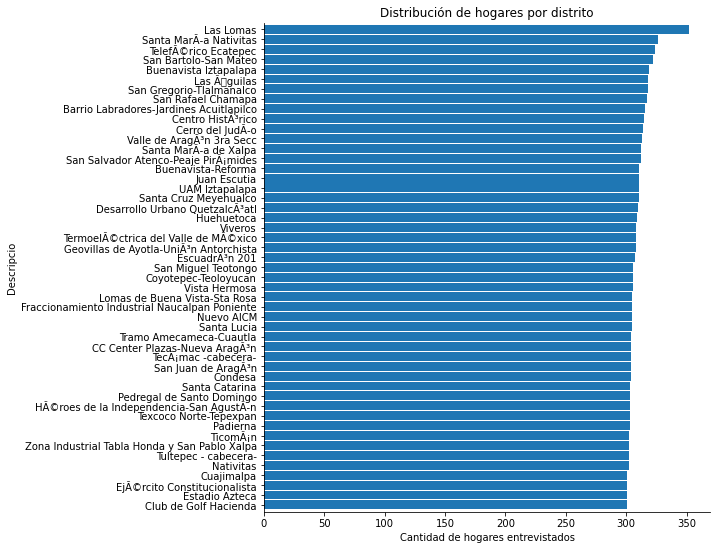

In [ ]:
hogares_por_barrio = encuestas_df.groupby("Descripcio").size().sort_values()

ax = hogares_por_barrio[-49:].plot(kind="barh", width=0.9, figsize=(8, 9))
ax.set_xlabel("Cantidad de hogares entrevistados")
ax.set_title("Distribución de hogares por distrito")
sns.despine()

¿Quienes son las personas encuestadas?

In [ ]:
personas_df.edad.describe()

count    200117.000000
mean         34.513784
std          20.871004
min           0.000000
25%          17.000000
50%          33.000000
75%          50.000000
max          99.000000
Name: edad, dtype: float64

In [ ]:
def age_cohorts(row, age_column):
    if row[age_column] < 18:
        return '<18'
    elif row[age_column] <=29 and row[age_column] > 18:
        return '18-29'
    elif row[age_column] <=60 and row[age_column] > 29:
        return '30-60'
    elif row[age_column] > 60 and row[age_column] < 100:
        return '>60'
    else:
        return 'No declarado'

In [ ]:
def normalize_rows(df):
    return df.pipe(lambda x: pd.DataFrame(normalize(df, axis=1, norm='l1'), columns=df.columns, index=df.index))

In [ ]:
personas_df['age_cohort'] = personas_df.apply(lambda row: age_cohorts(row, 'edad'), axis=1)

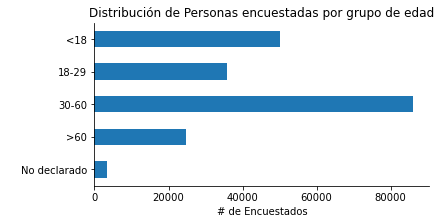

In [ ]:
order = ['<18', '18-29', '30-60','>60','No declarado']
ax = (personas_df.groupby(['age_cohort']).size().loc[reversed(order)]
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por grupo de edad")
sns.despine()

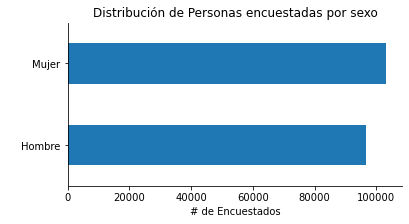

In [ ]:
ax = (personas_df.groupby(['sexo']).size()
 .plot(kind='barh', figsize=(6,3)))
ax.set_xlabel("# de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo")
sns.despine()

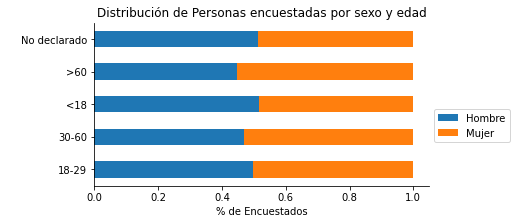

In [ ]:
ax = (personas_df.groupby(['age_cohort', 'sexo']).size().unstack()
 .pipe(normalize_rows)
 .plot(kind='barh', stacked=True, figsize=(6, 3)))
ax.set_xlabel("% de Encuestados")
ax.set_ylabel(" ")
ax.set_title("Distribución de Personas encuestadas por sexo y edad")
sns.despine()

plt.legend(loc=0, bbox_to_anchor=(1.0, 0.5))

### Parte I: Indicadores de Cantidad de Viajes

En esta primera parte, responderemos algunas preguntas respecto a indicadores de cantidades de viajes realizados, en días hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:

1. ¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?
2. ¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?
3. ¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?
4. ¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?

En esta sección, se detallarán los resultados para indicadores a nivel de viajes, separados por días hábiles y no hábiles de viaje, y por clasificador socioeconómico.

In [ ]:
print('Cantidad de viajes mapeados: totales encuesta , total expandido')
viajes_habiles = viajes_personas[viajes_personas.DIA_HABIL=='Si']
print('Total Viajes Habiles: {}'.format(viajes_habiles.shape[0]), viajes_habiles['factor_x'].sum())
viajes_nohabiles = viajes_personas[viajes_personas.DIA_NOHABIL=='Si']
print('Total Viajes No Habiles: {}'.format(viajes_nohabiles.shape[0]), viajes_nohabiles['factor_x'].sum())

Cantidad de viajes mapeados: totales encuesta , total expandido
Total Viajes Habiles: 329580 34565491
Total Viajes No Habiles: 202014 21364907


Separamos los viajes habiles y no habiles de acuerdo a si son privados o publicos

In [ ]:
viajes_publico_habiles = viajes_habiles[viajes_habiles.ModoViaje.isin(publico_viaje)]
viajes_publico_nohabiles = viajes_nohabiles[viajes_nohabiles.ModoViaje.isin(publico_viaje)]

viajes_privado_habiles = viajes_habiles[viajes_habiles.ModoViaje.isin(privado_viaje)]
viajes_privado_nohabiles = viajes_nohabiles[viajes_nohabiles.ModoViaje.isin(privado_viaje)]

In [ ]:
def weighted_mean(df, value_column, weighs_column):
    weighted_sum = (df[value_column] * df[weighs_column]).sum()
    return weighted_sum / df[weighs_column].sum()

In [ ]:
def weighted_median(df, val, weight):
    df_sorted = df.sort_values(val)
    cumsum = df_sorted[weight].cumsum()
    cutoff = df_sorted[weight].sum() / 2.
    return df_sorted[cumsum >= cutoff][val].iloc[0]

#### **¿Cuál es la tasa promedio de viajes diarios en transporte público por clasificador económico?**

Los siguientes gráficos muestran los viajes per cápita en trasporte público durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
from pandasql import sqldf
def calculate_n_viajes_per_capita(df, df_str, agg_columns_str, agg_columns_lst, id_person, person_weight, trip_weight=None):
    q = "SELECT DISTINCT {}, {}, {} FROM {}".format(id_person, agg_columns_str, person_weight, df_str)
    persons = sqldf(q, globals())
    n_personas = persons.groupby(agg_columns_lst).sum()[[person_weight]].reset_index()
    n_personas[agg_columns_lst[0]] = n_personas[agg_columns_lst[0]].astype(str)
    n_viajes = df.groupby(agg_columns_lst).sum()[[trip_weight]].reset_index()
    n_viajes[agg_columns_lst[0]] = n_viajes[agg_columns_lst[0]].astype(str)
    merged = pd.merge(n_personas, n_viajes, on=agg_columns_lst, how='left')
    merged['viajes_per_capita'] = merged[trip_weight] / merged[person_weight]
    return merged

In [ ]:
print('Viajes per cápita en transporte público - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_habiles, "viajes_publico_habiles", "estrato", ["estrato"], 'id_soc', 'factor_y', 'factor_x')

Viajes per cápita en transporte público - Día Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


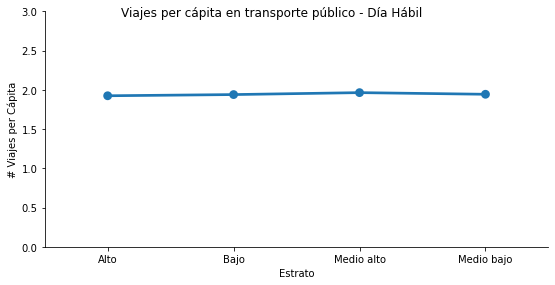

In [ ]:
#fig, ax = plt.subplots(figsize=(8,6))
g = sns.catplot(x="estrato", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Estrato')
g.set(ylim=(0,3))

#fig.tight_layout()

In [ ]:
print('Viajes per cápita en transporte público - Día No Hábil')
df = calculate_n_viajes_per_capita(viajes_publico_nohabiles, "viajes_publico_nohabiles", "estrato", ["estrato"], 'id_soc', 'factor_y', 'factor_x')
df

Viajes per cápita en transporte público - Día No Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


,estrato,factor_y,factor_x,viajes_per_capita
0,Alto,465115,852421,1.832710
1,Bajo,53036,100634,1.897466
2,Medio alto,1581783,2983916,1.886426
3,Medio bajo,2841586,5346445,1.881500


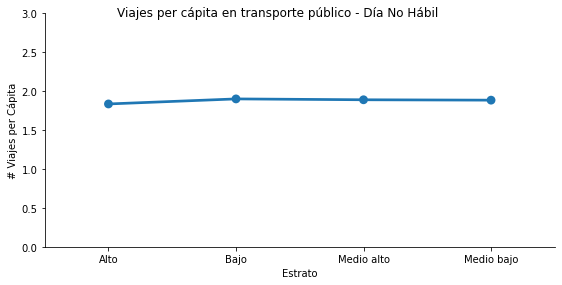

In [ ]:
g = sns.catplot(x="estrato", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte público - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Estrato')
g.set(ylim=(0,3))

#fig.tight_layout()

No hay diferencia de cantidad de viajes per cápita en transporte público entre días hábiles y no hábiles para los distintos estratos.

#### **¿Cuál es la tasa promedio de viajes diarios en transporte privado por clasificador económico?**

Los siguientes gráficos representan la tasa promedio de viajes diarios en el transporte privado durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Viajes per cápita en transporte privado - Día Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_habiles, "viajes_privado_habiles", "estrato", ["estrato"], 'id_soc', 'factor_y', 'factor_x')
df

Viajes per cápita en transporte privado - Día Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


,estrato,factor_y,factor_x,viajes_per_capita
0,Alto,1399746,3131978,2.237533
1,Bajo,79847,175562,2.198730
2,Medio alto,2600640,5671838,2.180939
3,Medio bajo,4635977,10167690,2.193214


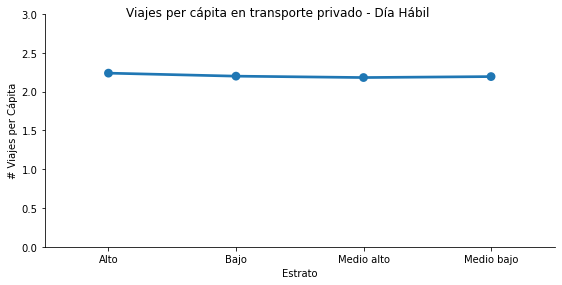

In [ ]:
g = sns.catplot(x="estrato", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Estrato')
g.set(ylim=(0,3))

#fig.tight_layout()

In [ ]:
print('Viajes per cápita en transporte privado - Día No Hábil')
df = calculate_n_viajes_per_capita(viajes_privado_nohabiles, "viajes_privado_nohabiles", "estrato", ["estrato"], 'id_soc', 'factor_y', 'factor_x')

Viajes per cápita en transporte privado - Día No Hábil


/usr/local/lib/python3.7/site-packages/pandasql/sqldf.py:121: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  index=not any(name is None for name in df.index.names))  # load index into db if all levels are named


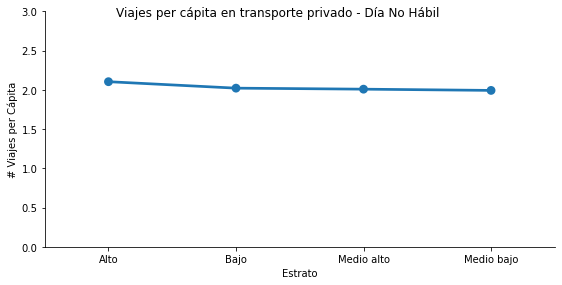

In [ ]:
g = sns.catplot(x="estrato", y="viajes_per_capita", 
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Viajes per cápita en transporte privado - Día No Hábil')
g.set_ylabels('# Viajes per Cápita')
g.set_xlabels('Estrato')
g.set(ylim=(0,3))

#fig.tight_layout()

No hay diferencia de cantidad de viajes per cápita en transporte privado entre días hábiles y no hábiles para los distintos estratos.

#### **¿Cuál es la razón entre los viajes en transporte público y privado por clasificador socioeconómico?**

Los gráficos a continuación muestran la razón entre los viajes en transporte público y transporte privado durante días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día Hábil')
df = viajes_privado_habiles.groupby(["estrato"]).agg(privado_sobre_publico = ('factor_x', 'sum')) / viajes_publico_habiles.groupby(["estrato"]).agg(privado_sobre_publico = ('factor_x', 'sum'))
df = df.reset_index()

Razón entre los viajes en transporte público y privado - Día Hábil


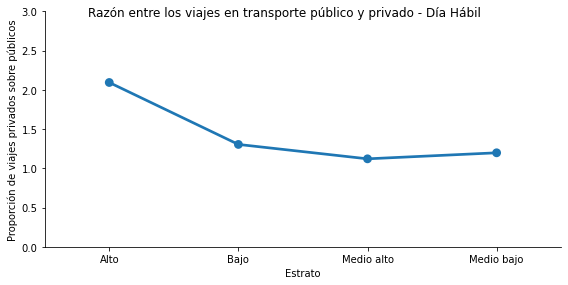

In [ ]:
g = sns.catplot(x="estrato", y="privado_sobre_publico",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Estrato')
g.set(ylim=(0,3))

#fig.tight_layout()

In [ ]:
print('Razón entre los viajes en transporte público y privado - Día No Hábil')
df = viajes_privado_nohabiles.groupby(["estrato"]).agg(privado_sobre_publico = ('factor_x', 'sum')) / viajes_publico_nohabiles.groupby(["estrato"]).agg(privado_sobre_publico = ('factor_x', 'sum'))
df = df.reset_index()

Razón entre los viajes en transporte público y privado - Día No Hábil


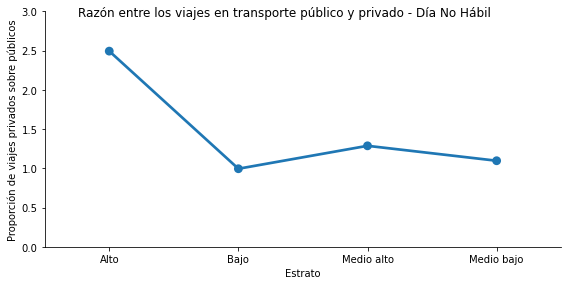

In [ ]:
g = sns.catplot(x="estrato", y="privado_sobre_publico",
                capsize=.2, height=4, aspect=2,
                kind="point", data=df)

g.fig.suptitle('Razón entre los viajes en transporte público y privado - Día No Hábil')
g.set_ylabels('Proporción de viajes privados sobre públicos')
g.set_xlabels('Estrato')
g.set(ylim=(0,3))

#fig.tight_layout()

En días hábiles y no hábiles, la diferencia de razón de viajes privados sobre públicos solo es evidente para la clasificación más alta.

#### **¿Cuál es la distribución/partición modal de los viajes por clasificador socioeconómico?**

Las siguientes tablas y gráficos representan la partición modal de los viajes realizados en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Partición Modal de los Viajes - Día Hábil')
df = viajes_habiles.groupby(["estrato","ModoViaje"]).sum()['factor_x'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes - Día Hábil


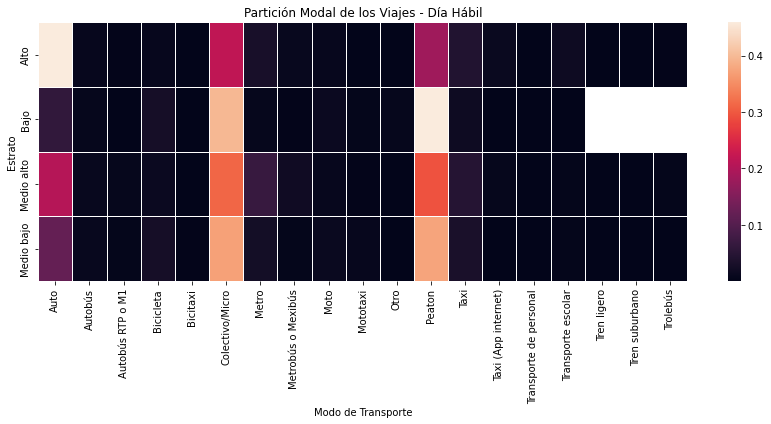

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes - Día No Hábil')
df = viajes_nohabiles.groupby(["estrato", "ModoViaje"]).sum()['factor_x'].unstack()
#.agg(count=('MEDIO_PREDOMINANTE','count')).unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes - Día No Hábil


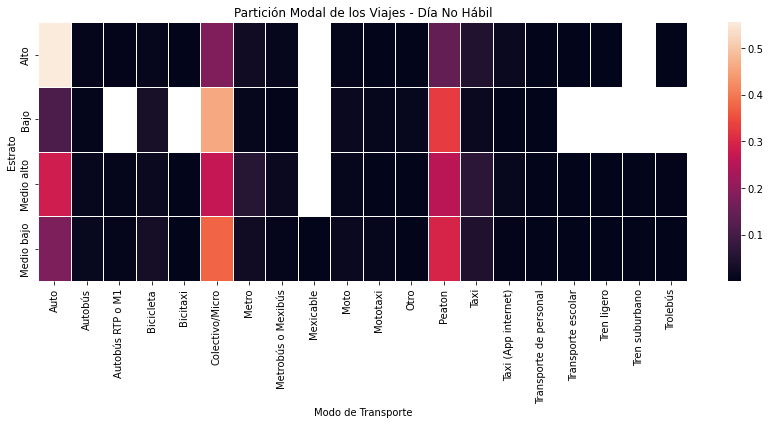

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.heatmap(df_norm,linewidth=0.5)

ax.set_title("Partición Modal de los Viajes - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

En días hábiles y no hábiles, los modos de transporte con mayor distribución de viajes son el auto, donde el uso es mayor a medida que se sube de estrato, y Colectivo/Micro y Peatón, donde el uso aumenta a medida que disminuye el estrato.

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil')
df = viajes_habiles.groupby(["estrato", "publico_privado"]).sum()['factor_x'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil


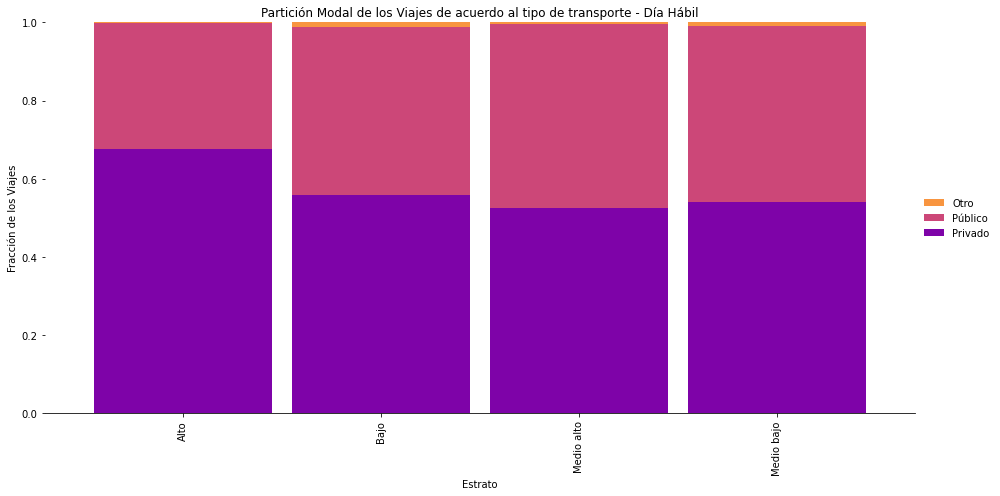

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día Hábil")
ax.set_ylim([0, 1])
ax.set_ylabel("Fracción de los Viajes")
ax.set_xlabel("Estrato")

fig.tight_layout()

In [ ]:
print('Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil')
df = viajes_nohabiles.groupby(["estrato", 'publico_privado']).sum()['factor_x'].unstack()
df_norm = df.div(df.sum(axis=1), axis=0)

Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil


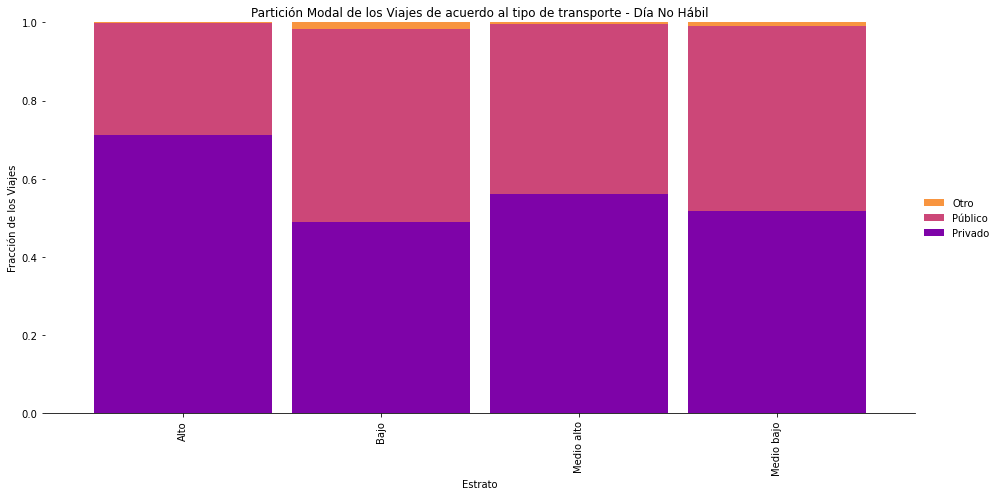

In [ ]:
from aves.visualization.tables import barchart

fig, ax = plt.subplots(figsize=(14, 7))

barchart(
    ax, df_norm, stacked=True, normalize=False, sort_categories=True, sort_items=False
)

ax.set_title("Partición Modal de los Viajes de acuerdo al tipo de transporte - Día No Hábil")
ax.set_ylim([0, 1])
ax.set_ylabel("Fracción de los Viajes")
ax.set_xlabel("Estrato")

fig.tight_layout()

En ambos tipos de días, la fracción de viajes realizados en transporte privado aumenta a medida que aumenta el estrato.

### Parte II: Indicadores de Tiempo de Viajes

En esta segunda parte, responderemos algunas preguntas respecto a indicadores de tiempo de viajes realizados, en días hábiles de viaje. Para esto, buscaremos responder las siguientes preguntas:
1. ¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?
2. ¿Cuál es el tiempo promedio de viaje en hora punta de mañana?
3. ¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?
4. ¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?

En esta sección, se presentarán los indicadores de tiempo de viajes a nivel de viajes, durante días hábiles, y por clasificador socioeconómico.

In [ ]:
viajes_habiles['duracion_minutos'] = pd.to_timedelta(viajes_habiles['duracion'])/pd.Timedelta('60s')
viajes_nohabiles['duracion_minutos'] = pd.to_timedelta(viajes_nohabiles['duracion'])/pd.Timedelta('60s')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### **¿Cuál es el tiempo promedio de viaje por modo y tipo de transporte?**

A continuación, se representa el promedio y mediana en minutos de viaje por modo y tipo de transporte en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por modo - Dia Hábil


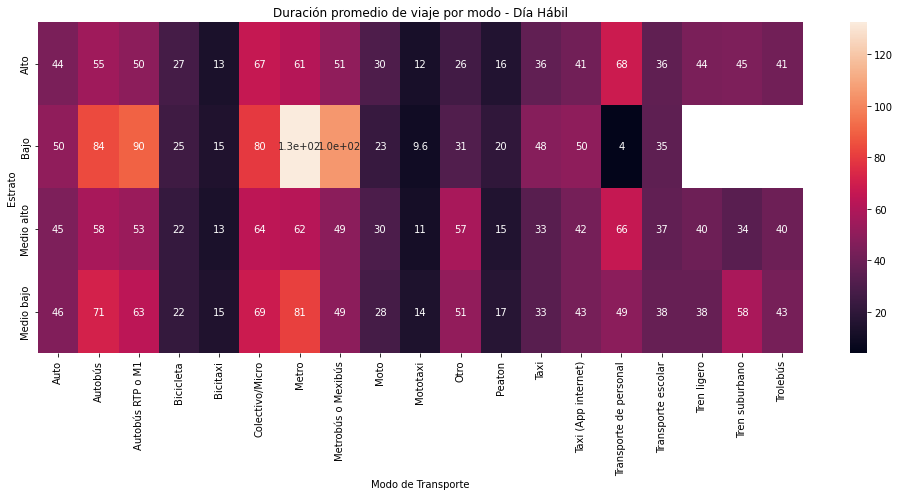

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia Hábil')
df = viajes_habiles.groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por modo - Dia Hábil


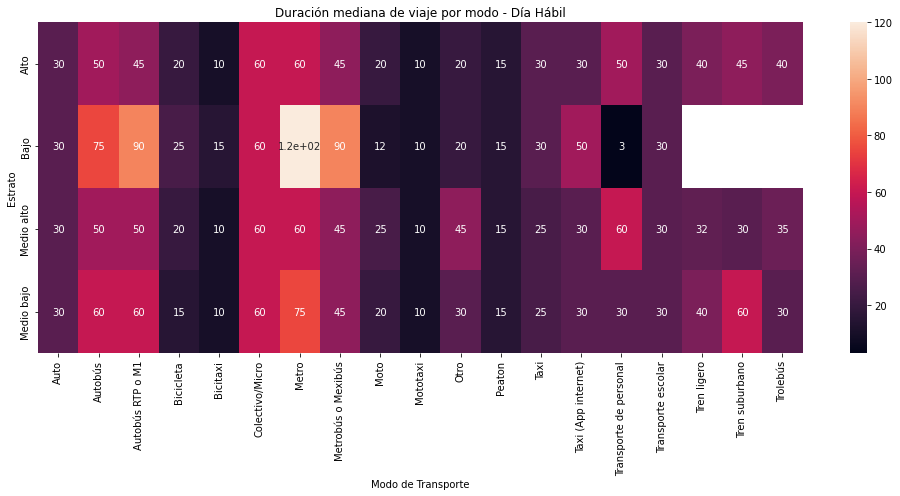

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por modo - Dia No Hábil')
df = viajes_nohabiles.groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por modo - Dia No Hábil


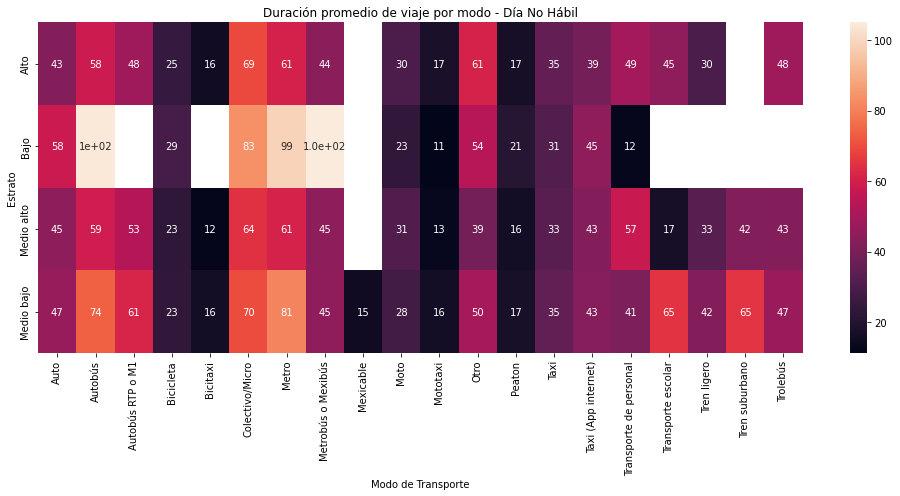

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo - Dia No Hábil')
df = viajes_nohabiles.groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por modo - Dia No Hábil


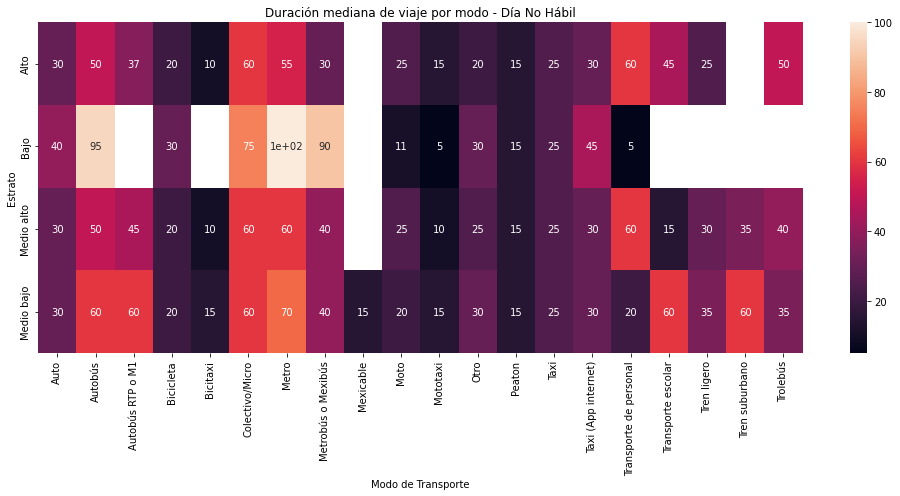

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

Durante días hábiles, los viajes con mayor duración promedio con los realizados en Metro, mientras que los viajes con menor duración promedio son los realizados en Mototaxi. En días no hábiles, los viajes con mayor duración promedio son los realizados en Metrobus o Autobus.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["estrato", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte - Dia Hábil


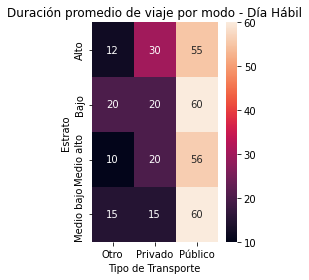

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil')
df = viajes_habiles.groupby(["estrato", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte - Dia Hábil


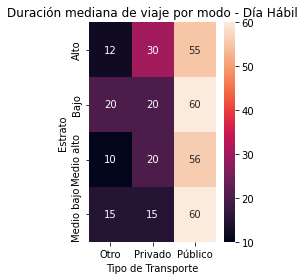

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte (Motorizado/No Motorizado) - Dia Hábil')
df = viajes_nohabiles.groupby(["estrato", 'motorizado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte (Motorizado/No Motorizado) - Dia Hábil


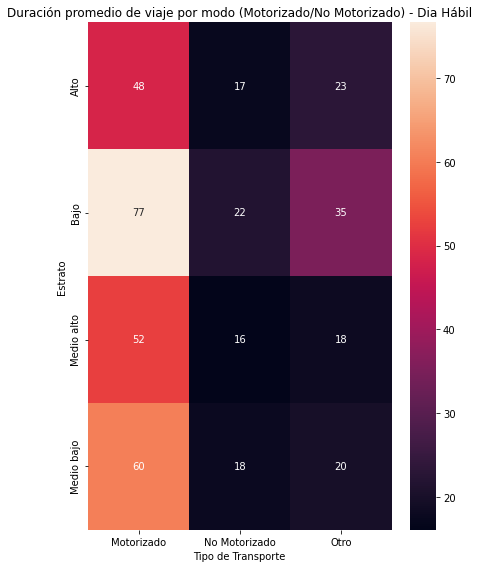

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo (Motorizado/No Motorizado) - Dia Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración median (en minutos) de viaje por tipo de transporte (Motorizado/No Motorizado) - Dia Hábil')
df = viajes_nohabiles.groupby(["estrato", 'motorizado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración median (en minutos) de viaje por tipo de transporte (Motorizado/No Motorizado) - Dia Hábil


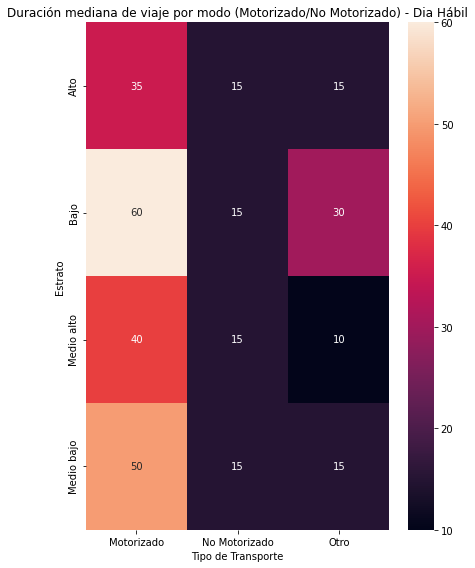

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo (Motorizado/No Motorizado) - Dia Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

Por tipo de transporte, tanto en días hábiles como no hábiles, los viajes realizados en transporte público tienen mayor duración que los realizados en transporte privado.

#### **¿Cuál es el tiempo promedio de viaje en hora punta de mañana?**

Estos son los resultados para el promedio y mediana en minutos de viaje en hora punta de la mañana por modo de transporte, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por modo en hora punta - Dia Hábil


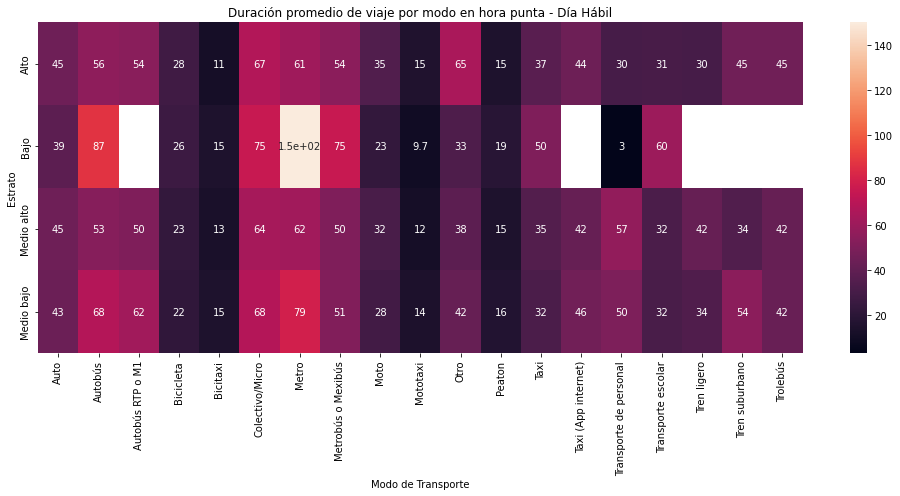

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil')
df = viajes_habiles[viajes_habiles.PICO_HABIL=='Si'].groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia Hábil


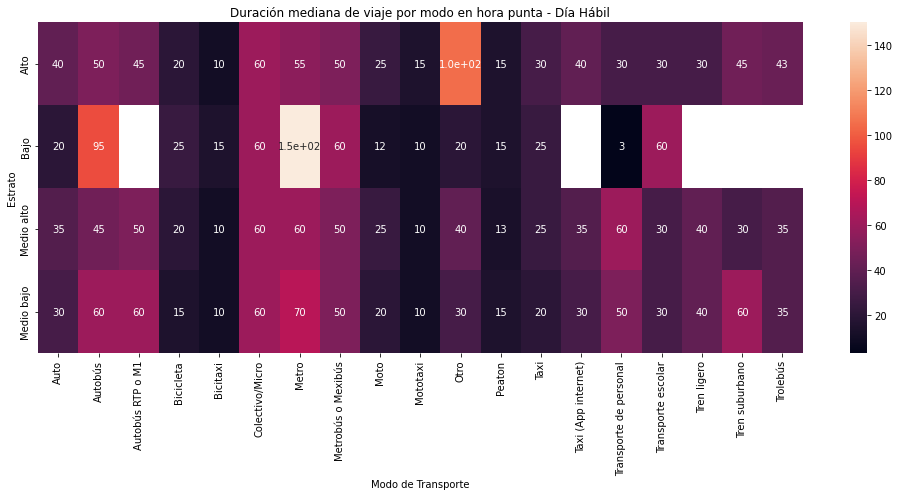

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración promedio (en minutos) de viaje por modo en hora punta - Dia No Hábil')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'].groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por modo en hora punta - Dia No Hábil


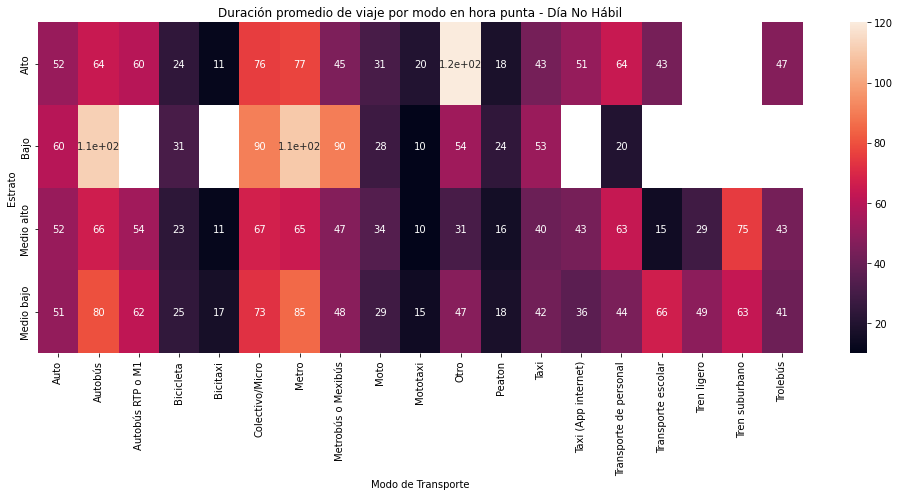

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por modo en hora punta - Dia No Hábil')
df = viajes_nohabiles[viajes_nohabiles.PICO_NOHABIL=='Si'].groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por modo en hora punta - Dia No Hábil


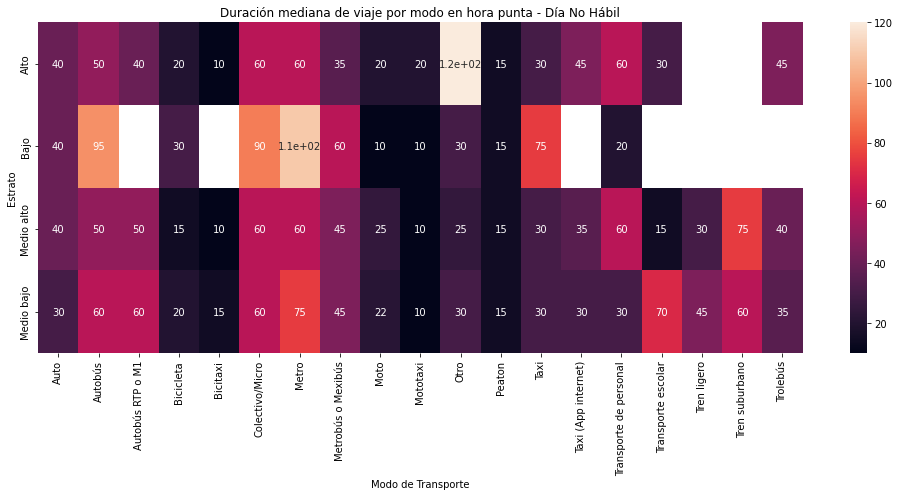

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta - Día No Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

En días hábiles y no hábiles, los viajes realizados en hora punta de mañana con mayor duración corresponden a los realizados en Metro y Autobus, y esta duración aumenta a medida que se baja de estrato.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["estrato", 'publico_privado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


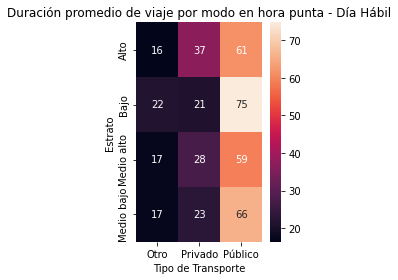

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["estrato", 'publico_privado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte en hora punta - Dia Hábil


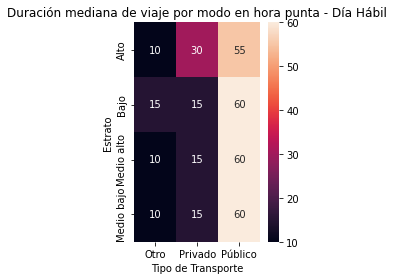

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

Para ambos tipos de días, los viajes realizados en hora punta de mañana en transporte público tienen una mayor duración que los realizados en transporte privado.

In [ ]:
print('Duración promedio (en minutos) de viaje por tipo de transporte (Motorizado/No motorizado) en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["estrato", 'motorizado']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje por tipo de transporte (Motorizado/No motorizado) en hora punta - Dia Hábil


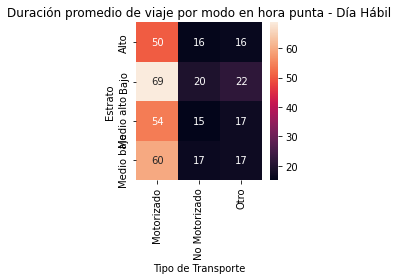

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje por tipo de transporte (motorizado/no motorizado) en hora punta - Dia Hábil')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')].groupby(["estrato", 'motorizado']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje por tipo de transporte (motorizado/no motorizado) en hora punta - Dia Hábil


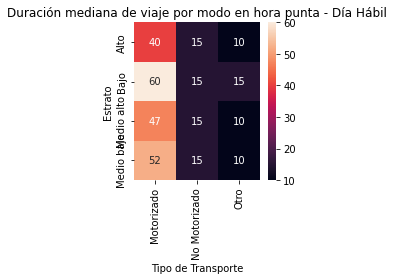

In [ ]:
fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta - Día Hábil")
ax.set_xlabel("Tipo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

#### **¿Cuál es el tiempo de viaje en transporte público en hora punta de mañana?**

A continuación, se presentan los resultados para duración promedio de viaje en hora punta de mañana en transporte público, en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')][mask].groupby(["estrato", 'ModoViaje']).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


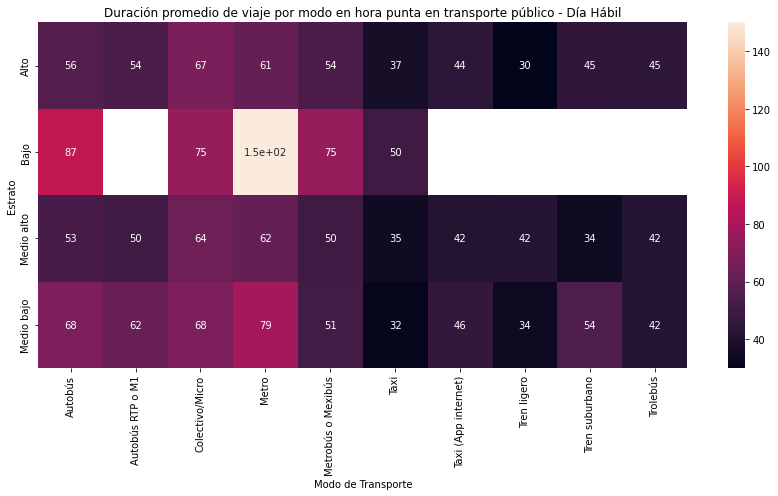

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje por modo en hora punta en transporte público - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje hora punta en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público')
df = viajes_habiles[(viajes_habiles.PICO_HABIL=='Si')][mask].groupby(["estrato", 'ModoViaje']).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje hora punta en transporte público - Dia Hábil


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


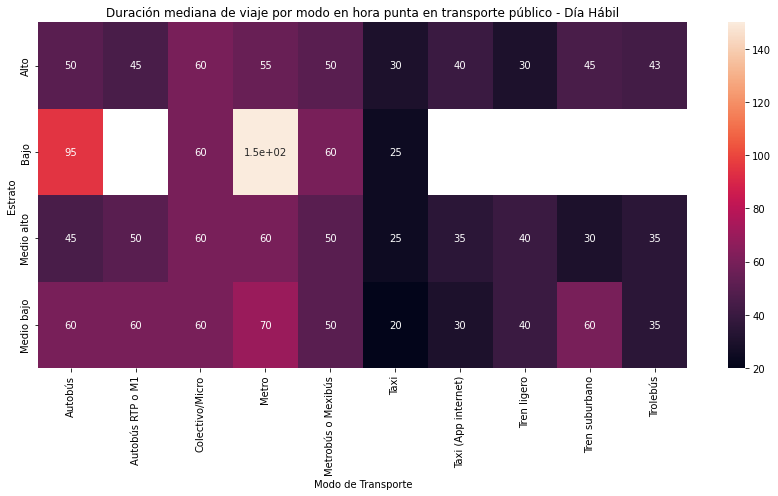

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje por modo en hora punta en transporte público - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

Tanto en días hábiles, los modos de transporte con mayor duración de viaje en transporte público en hora punta de mañana son el Metro y Autobús, y estos tiempos aumentan al bajar de estrato.

#### **¿Cuál es el tiempo promedio de viaje al trabajo en transporte público?**

A continuación, se presentan los resultados de tiempo promedio de viaje al trabajo en transporte público por modo en días hábiles y no hábiles, por clasificador socioeconómico.

In [ ]:
print('Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.p5_13==2)
df = viajes_habiles[mask].groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_mean(x, 'duracion_minutos', 'factor_x')).unstack()

Duración promedio (en minutos) de viaje al trabajo en transporte público - Dia Hábil


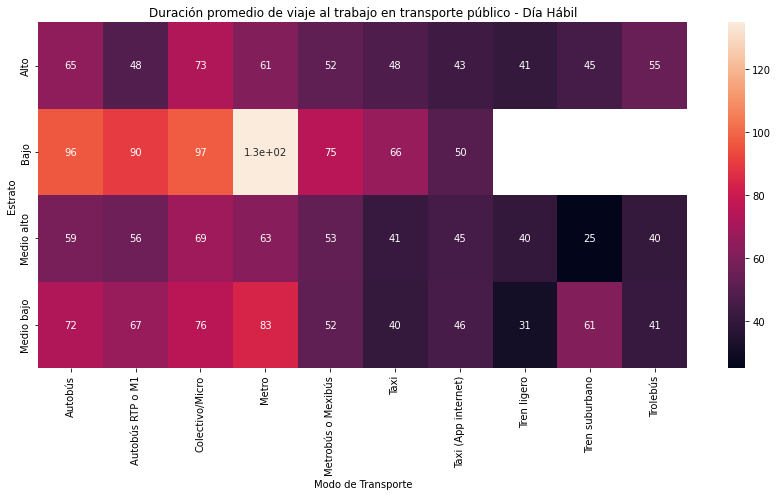

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración promedio de viaje al trabajo en transporte público - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

In [ ]:
print('Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil')
mask = (viajes_habiles.publico_privado=='Público') & (viajes_habiles.p5_13==2)
df = viajes_habiles[mask].groupby(["estrato", "ModoViaje"]).apply(lambda x: weighted_median(x, 'duracion_minutos', 'factor_x')).unstack()

Duración mediana (en minutos) de viaje al trabajo en transporte público - Dia Hábil


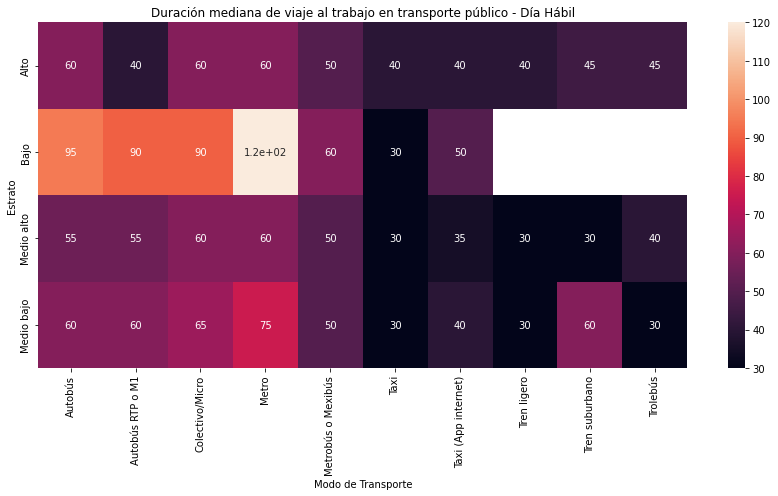

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

ax = sns.heatmap(df, annot=True)

ax.set_title("Duración mediana de viaje al trabajo en transporte público - Día Hábil")
ax.set_xlabel("Modo de Transporte")
ax.set_ylabel("Estrato")

fig.tight_layout()

Tanto en días hábiles, los modos de transporte con mayor duración de viaje al trabajo en transporte público son el Metro y Autobús, y estos tiempos aumentan al bajar de estrato.

### Parte III: Indicadores de Distancia de Viajes
1. Distancia de viajes en auto (histograma de viajes por km)
2.Distancia de viajes en transporte público (histograma de viajes por km)
3.Distancia de viajes por motivo estudio (histograma de viajes por km)
4.Distancia de viajes por motivo al trabajo (histograma de viajes por km)
5.Viajes interzonales como intrazonales


En esta sección, se presentarán los indicadores de distancia de viajes durante días hábiles.

#### **Distancia de viajes en auto (histograma de viajes por km)**

Distancia de viajes en auto - Día Hábil


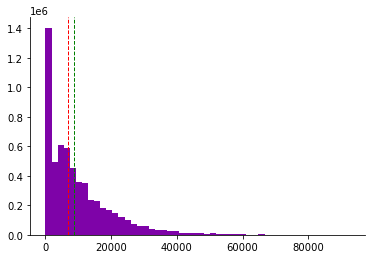

In [ ]:
from matplotlib.pyplot import hist
print('Distancia de viajes en auto - Día Hábil')
mask = (viajes_habiles.ModoViaje == 'Auto')
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['factor_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.factor_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_via').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_via').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'factor_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

Distancia de viajes en auto - Día No Hábil


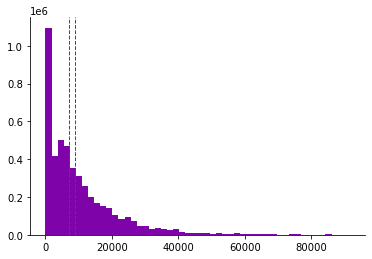

In [ ]:
print('Distancia de viajes en auto - Día No Hábil')
mask = (viajes_nohabiles.ModoViaje == 'Auto')
df = viajes_nohabiles[mask].groupby('distancia_manhattan').sum()[['factor_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.factor_x, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('id_via').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('id_via').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'factor_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes en transporte público**

Distancia de viajes en transporte público - Día Hábil


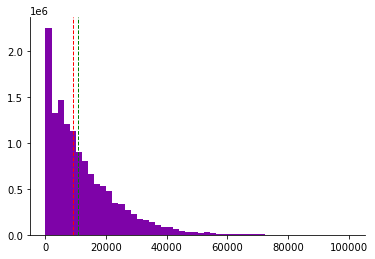

In [ ]:
print('Distancia de viajes en transporte público - Día Hábil')
mask = (viajes_habiles.publico_privado == 'Público')
df = viajes_habiles[mask].groupby('distancia_manhattan').sum()[['factor_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.factor_x, bins=50)
plt.axvline(viajes_habiles[mask].groupby('id_via').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_habiles[mask].groupby('id_via').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'factor_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

Distancia de viajes en transporte público - Día No Hábil


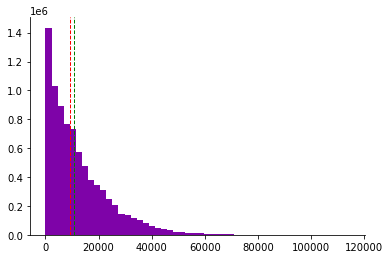

In [ ]:
print('Distancia de viajes en transporte público - Día No Hábil')
mask = (viajes_nohabiles.publico_privado == 'Público')
df = viajes_nohabiles[mask].groupby('distancia_manhattan').sum()[['factor_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.factor_x, bins=50)
plt.axvline(viajes_nohabiles[mask].groupby('id_via').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_nohabiles[mask].groupby('id_via').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'factor_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo estudio**

Distancia de viajes con motivo de estudio


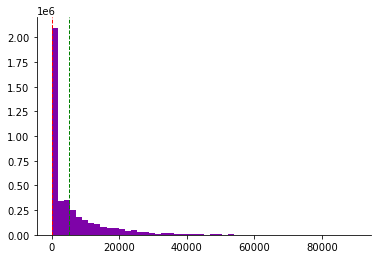

In [ ]:
print('Distancia de viajes con motivo de estudio')
mask = (viajes_personas.p5_13==3)
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['factor_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.factor_x, bins=50)
plt.axvline(viajes_personas[mask].groupby('id_via').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('id_via').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'factor_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Distancia de viajes por motivo trabajo**

Distancia de viajes con motivo de trabajo


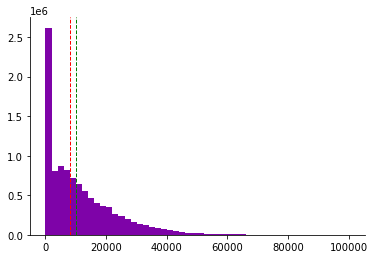

In [ ]:
print('Distancia de viajes con motivo de trabajo')
mask = (viajes_personas.p5_13 == 2)
df = viajes_personas[mask].groupby('distancia_manhattan').sum()[['factor_x']].reset_index().sort_values('distancia_manhattan')
hist(df.distancia_manhattan, weights=df.factor_x, bins=50)
plt.axvline(viajes_personas[mask].groupby('id_via').apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x')).mean(), color='green', linestyle='dashed', linewidth=1)
plt.axvline(viajes_personas[mask].groupby('id_via').apply(lambda x: weighted_median(x, 'distancia_manhattan', 'factor_x')).median(), color='red', linestyle='dashed', linewidth=1)
sns.despine()
#Verde Promedio
#Rojo Mediana

#### **Viajes intra vs interzonales**

In [ ]:
viajes_personas.p5_13 = decode_column(viajes_personas, data_path + 'eod_2017_csv/tviaje_eod2017/catalogos/p5_13.csv', 'p5_13')

In [ ]:
print('% de viajes Inter e Intra zonales')
df = viajes_personas.groupby(['p5_13','sexo','Intra_Inter']).sum()['factor_x'].unstack()
df.div(df.sum(axis=1), axis=0)

% de viajes Inter e Intra zonales


Intra_Inter                                                   Inter     Intra
p5_13                                              sexo                      
Convivir a(amigos o familiares) deportes o recr... Hombre  0.697889  0.302111
                                                   Mujer   0.694084  0.305916
Hacer un trámite                                   Hombre  0.753513  0.246487
                                                   Mujer   0.708327  0.291673
Ir a acto religioso                                Hombre  0.519185  0.480815
                                                   Mujer   0.481449  0.518551
Ir a estudiar                                      Hombre  0.526991  0.473009
                                                   Mujer   0.534544  0.465456
Ir al hogar                                        Hombre  0.695395  0.304605
                                                   Mujer   0.562489  0.437511
Ir al médico o recibir atención de salud           Hombre  0.785393  0.214607
                                                   Mujer   0.772030  0.227970
Ir al trabajo                                      Hombre  0.784441  0.215559
                                                   Mujer   0.752529  0.247471
Ir de compras (bienes y servicios)                 Hombre  0.512495  0.487505
                                                   Mujer   0.369983  0.630017
Llevar o recoger a alguien                         Hombre  0.623345  0.376655
                                                   Mujer   0.371003  0.628997
No sabe                                            Hombre  0.681098  0.318902
                                                   Mujer   0.539991  0.460009
Otro                                               Hombre  0.666353  0.333647
                                                   Mujer   0.640887  0.359113

#### **¿Dónde se concentran las personas que utilizan cada modo de transporte en la ciudad para distintos propósitos?**

<AxesSubplot:>

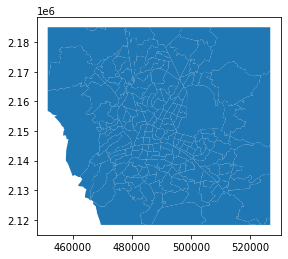

In [ ]:
from aves.features.geo import clip_area_geodataframe
bbox = [451422.4927,2118246.2863,526702.0629,2185113.0905]

zonas_en_caja = clip_area_geodataframe(city_shp.to_crs('epsg:32614'), bbox)
zonas_en_caja.plot()

In [ ]:
bounds = zonas_en_caja.to_crs('EPSG:4686').total_bounds

In [ ]:
import contextily as cx

scl_img, scl_ext = cx.bounds2raster(bounds[0], bounds[1], bounds[2], bounds[3], 
    "mexico_toner_12.tif",
    ll=True,
    source=cx.providers.Stamen.TonerBackground,
    zoom=12,
)

In [ ]:
from aves.features.geo import to_point_geodataframe

In [ ]:
origenes_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_ORIGEN' , 'LATITUD_ORIGEN', crs='epsg:32614')
destinos_viajes = to_point_geodataframe(viajes_personas, 'LONGITUD_DESTINO', 'LATITUD_DESTINO', crs='epsg:32614')

In [ ]:
from aves.features.geo import clip_point_geodataframe

origenes_viajes = origenes_viajes[(origenes_viajes['id_via'].isin(destinos_viajes['id_via']))]
origenes_viajes = clip_point_geodataframe(origenes_viajes, zonas_en_caja.total_bounds)
destinos_viajes = destinos_viajes[(destinos_viajes['id_via'].isin(origenes_viajes['id_via']))]
destinos_viajes = clip_point_geodataframe(destinos_viajes, zonas_en_caja.total_bounds)

In [ ]:
origenes_viajes.ModoViaje.unique()

array(['Metrobús o Mexibús', 'Peaton', 'Taxi', 'Auto', 'Metro',
       'Colectivo/Micro', 'Moto', 'Taxi (App internet)', 'Bicicleta',
       'Autobús RTP o M1', 'Trolebús', 'Autobús', 'Otro',
       'Transporte escolar', 'Tren ligero', 'Transporte de personal',
       'Bicitaxi', 'Tren suburbano', 'Mototaxi', 'Mexicable'],
      dtype=object)

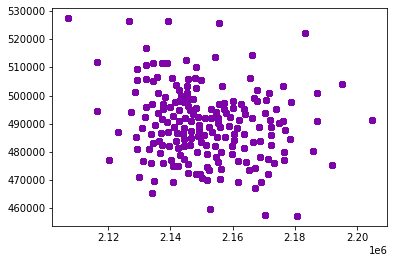

In [ ]:
plt.scatter(x=origenes_viajes['LATITUD_ORIGEN'], y=origenes_viajes['LONGITUD_ORIGEN'])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


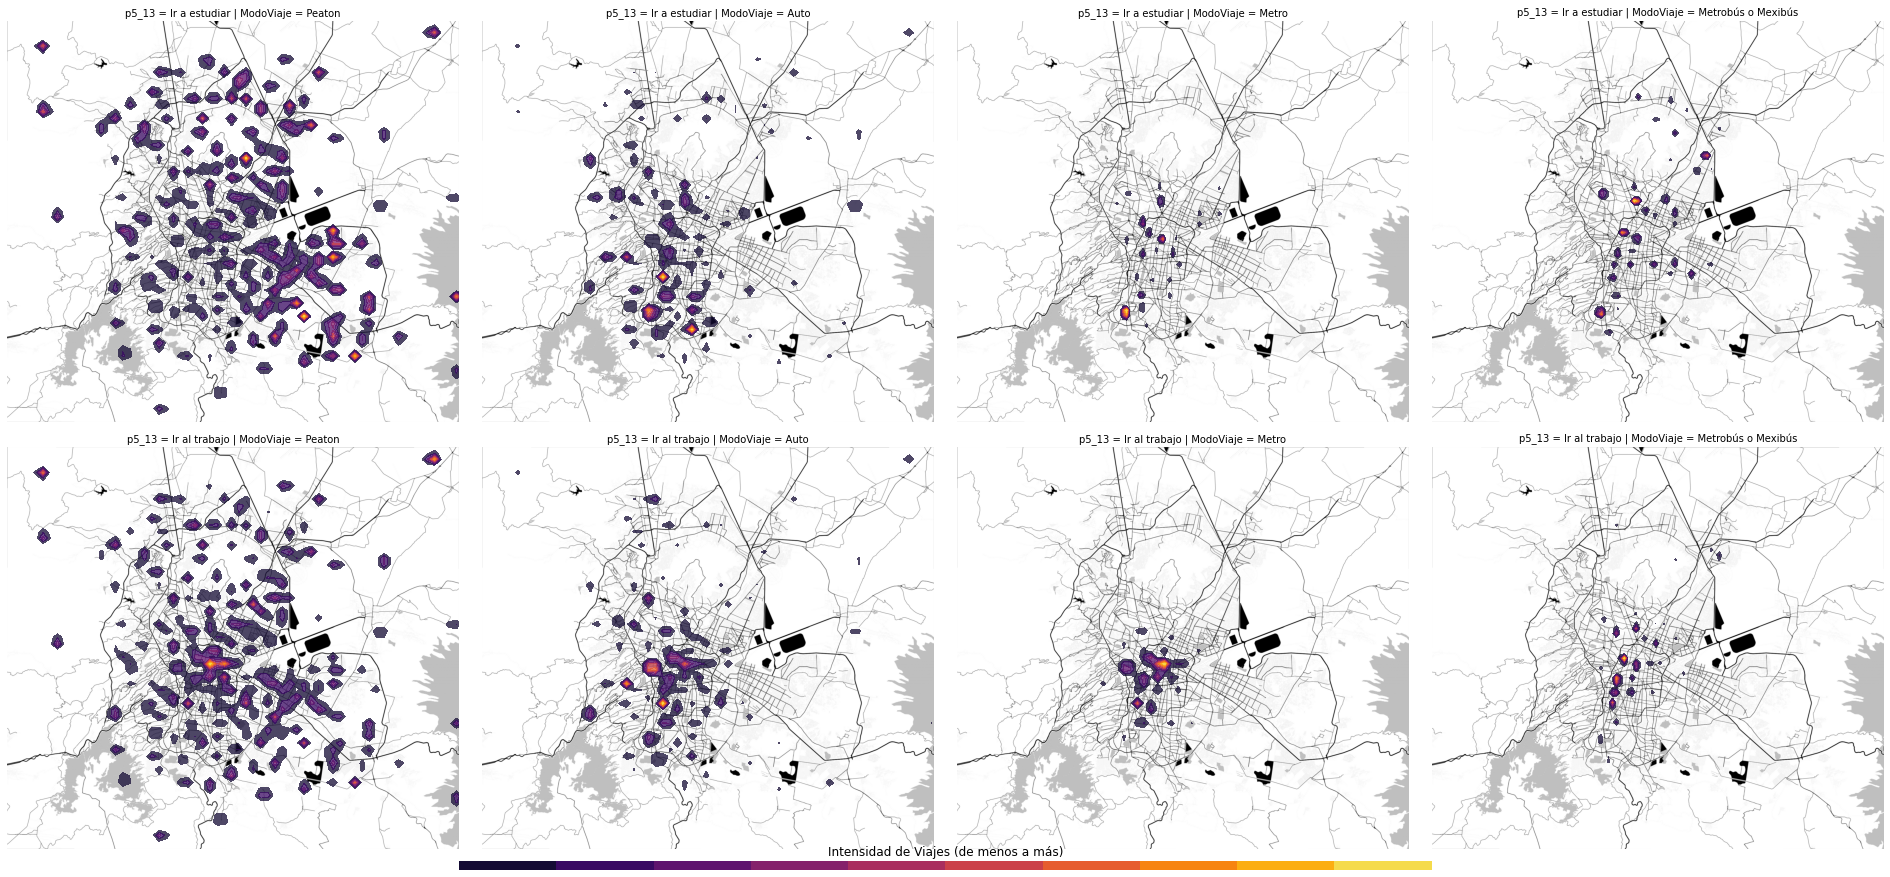

In [ ]:
from aves.visualization.figures import GeoFacetGrid

from aves.visualization.maps import heat_map

grid = GeoFacetGrid(
    origenes_viajes,
    context=zonas_en_caja,
    row="p5_13",
    col="ModoViaje",
    row_order=["Ir a estudiar", "Ir al trabajo"],
    col_order=["Peaton", "Auto", "Metro", "Metrobús o Mexibús"],
    height=6,
    hue="ModoViaje"
)
grid.add_basemap("mexico_toner_12.tif")
#grid.add_layer(city_shp_filt, color="#efefef", edgecolor="white", linewidth=1)

grid.add_layer(
    heat_map,
    # atributo de los datos con la importancia o peso de cada viaje
    weight="factor_x",
    # cantidad de niveles/colores del mapa de calor
    n_levels=10,
    # radio de influencia de cada viaje
    bandwidth=0.5,
    # valor de corte para los valores bajos del heatmap
    low_threshold=0.075,
    # transparencia
    alpha=0.75,
    # paleta de colores
    palette="inferno"
)

grid.add_global_colorbar('inferno', 10, title='Intensidad de Viajes (de menos a más)', orientation='horizontal')
#grid.set_title("Viajes a trabajar y a estudiar de acuerdo al modo de transporte")
grid.fig.tight_layout()

¿Cuán lejos queda el trabajo de acuerdo al lugar de residencia?

Con esta pregunta queremos entender si existe un patrón geográfico en las elecciones de residencia y trabajo de las personas.

Para responder la pregunta, primero filtramos los viajes que nos interesan:

In [ ]:
viajes_total = origenes_viajes[(pd.notnull(origenes_viajes.factor_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['id_via', 'id_soc'], keep='first')

In [ ]:
viajes_habiles = origenes_viajes[(origenes_viajes.DIA_HABIL=='Si') &
                                 (pd.notnull(origenes_viajes.factor_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['id_via', 'id_soc'], keep='first')

In [ ]:
viajes_trabajo = origenes_viajes[(origenes_viajes.p5_13 == 'Ir al trabajo') &
                                (pd.notnull(origenes_viajes.factor_x)) &
                                (origenes_viajes.distancia_manhattan > 0)].drop_duplicates(subset=['id_via', 'id_soc'], keep='first')
                                
print(len(viajes_trabajo), viajes_trabajo.factor_x.sum())

0 0


In [ ]:
viajes_trabajo.columns

Index(['id_via', 'id_soc', 'p5_3', 'dto_origen', 'dto_dest', 'p5_9_1',
       'p5_9_2', 'p5_10_1', 'p5_10_2', 'p5_13', 'estrato', 'factor_x',
       'ModoViaje', 'publico_privado', 'motorizado', 'LATITUD_ORIGEN',
       'LONGITUD_ORIGEN', 'LATITUD_DESTINO', 'LONGITUD_DESTINO', 'DIA_HABIL',
       'DIA_NOHABIL', 'distancia_manhattan', 'Intra_Inter', 'HORA_INICIO',
       'HORA_FIN', 'duracion', 'PICO_HABIL', 'PICO_NOHABIL', 'factor_y',
       'edad', 'id_hog', 'sexo', 'distrito', 'geometry'],
      dtype='object')

In [ ]:
distancia_zonas_mean = (viajes_trabajo
                   .groupby(['dto_origen'])
                   .apply(lambda x: weighted_mean(x, 'distancia_manhattan', 'factor_x'))
                   .rename('media_distancia_al_trabajo')
)

/usr/local/lib/python3.7/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


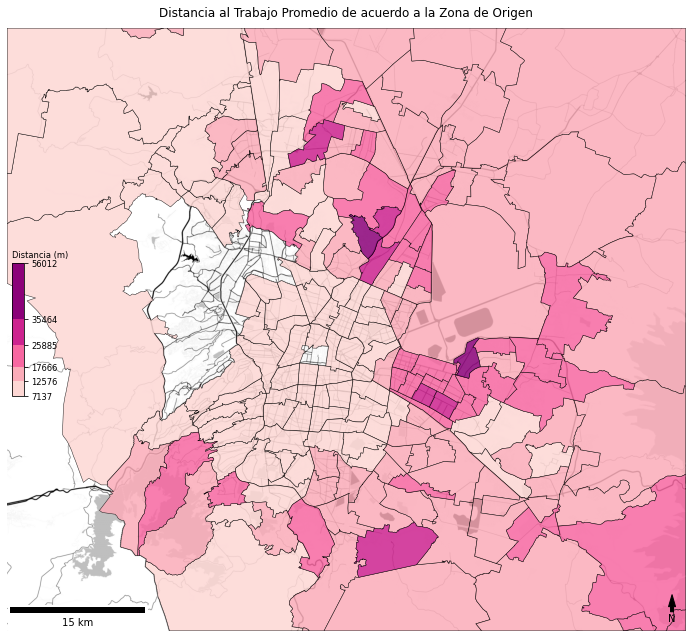

In [ ]:
from aves.visualization.maps import choropleth_map
grid = GeoFacetGrid(zonas_en_caja.join(distancia_zonas_mean, how="left"), height=9)
grid.add_basemap("mexico_toner_12.tif")
grid.add_layer(
    choropleth_map,
    "media_distancia_al_trabajo",
    k=5,
    linewidth=0.5,
    edgecolor="black",
    binning="fisher_jenks",
    palette="RdPu",
    alpha=0.85,
    cbar_args=dict(
        label="Distancia (m)",
        height="22%",
        width="2%",
        orientation="vertical",
        location="center left",
        label_size="small",
        bbox_to_anchor=(0.0, 0.0, 0.9, 1.0),
    ),
)
grid.add_map_elements()
grid.set_title("Distancia al Trabajo Promedio de acuerdo a la Zona de Origen")
grid.tight_layout()

In [ ]:
matriz_zonas = (viajes_total[(viajes_total['dto_origen'] != viajes_total['dto_dest'])
                             & (viajes_total['dto_origen'].isin(zonas_en_caja.Distrito))
                             & (viajes_total['dto_dest'].isin(zonas_en_caja.Distrito))]
                    .groupby(['dto_origen', 'dto_dest'])
                    .agg(n_viajes=('factor_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + 'matriz_zonas_todos_mexico2017.csv', index=False)

In [ ]:
matriz_zonas = (viajes_habiles[(viajes_habiles['dto_origen'] != viajes_habiles['dto_dest'])
                             & (viajes_habiles['dto_origen'].isin(zonas_en_caja.Distrito))
                             & (viajes_habiles['dto_dest'].isin(zonas_en_caja.Distrito))]
                    .groupby(['dto_origen', 'dto_dest'])
                    .agg(n_viajes=('factor_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + 'matriz_zonas_habiles_mexico2017.csv', index=False)

In [ ]:
matriz_zonas = (viajes_trabajo[(viajes_trabajo['dto_origen'] != viajes_trabajo['dto_dest'])
                            & (viajes_trabajo.DIA_HABIL=='Si')
                             & (viajes_trabajo['dto_origen'].isin(zonas_en_caja.Distrito))
                             & (viajes_trabajo['dto_dest'].isin(zonas_en_caja.Distrito))]
                    .groupby(['dto_origen', 'dto_dest'])
                    .agg(n_viajes=('factor_x', 'sum'))
                    .sort_values('n_viajes', ascending=False)
                    .assign(cumsum_viajes=lambda x: x['n_viajes'].cumsum())
                    .assign(cumsum_viajes=lambda x: x['cumsum_viajes'] / x['cumsum_viajes'].max())
                    .reset_index()
)
matriz_zonas.to_csv(data_path + 'matriz_zonas_trabajo_mexico2017.csv', index=False)

In [ ]:
matriz_zonas = matriz_zonas[matriz_zonas['cumsum_viajes'] <= 0.45]

In [ ]:
merged_zones = zonas_en_caja.dissolve('Distrito')#.drop('id', axis=1)

In [ ]:
from aves.models.network import Network
from aves.visualization.networks import NodeLink

zone_od_network = Network.from_edgelist(
    matriz_zonas, source="dto_origen", target="dto_dest", weight="n_viajes"
)

In [ ]:
zone_nodelink = NodeLink(zone_od_network)

In [ ]:
zone_nodelink.layout_nodes(method="geographical", geodataframe=merged_zones)

In [ ]:
zone_nodelink.set_node_drawing("plain", weights=zone_od_network.node_degree("in"))
zone_nodelink.set_edge_drawing(method="origin-destination")

In [ ]:
zone_nodelink.bundle_edges(
    method="force-directed", K=10, S=500, I=30, compatibility_threshold=0.65, C=6
)

In [ ]:
def plot_network(ax, geo_data, *args, **kwargs):
    zone_nodelink.plot(ax, *args, **kwargs)

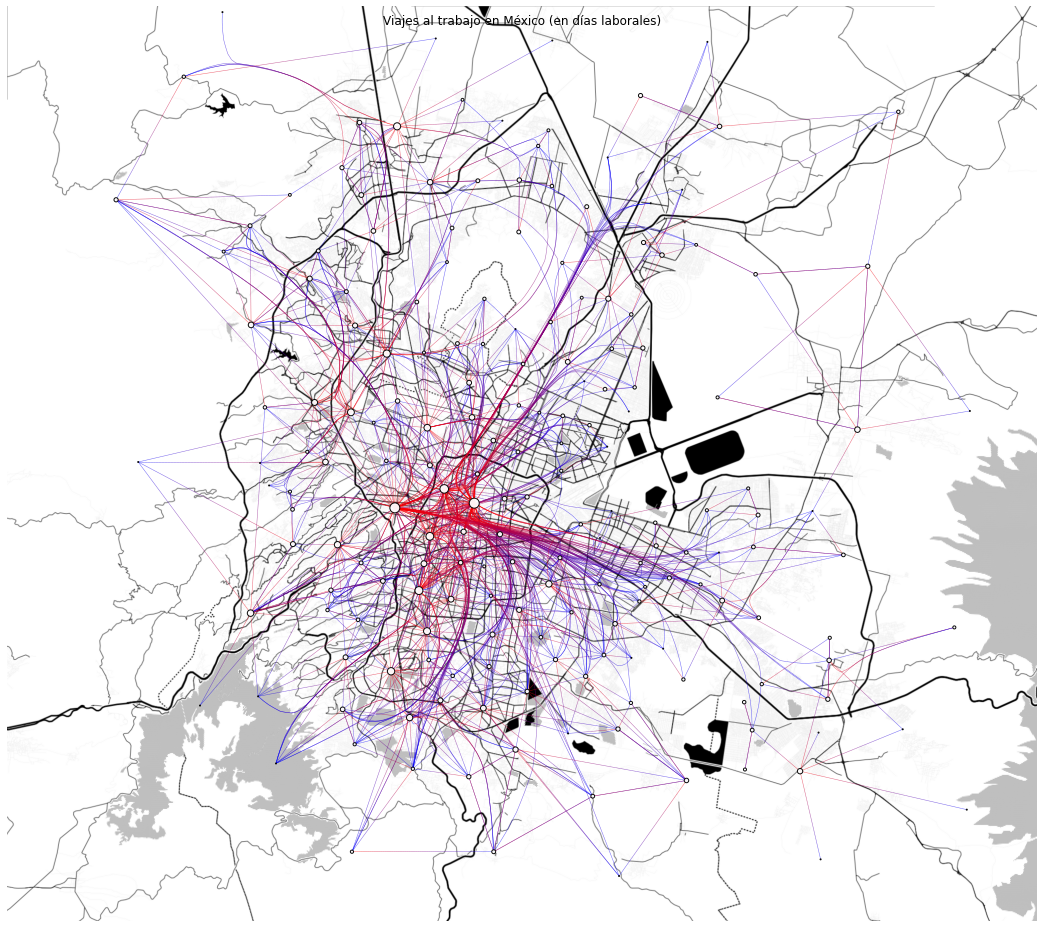

In [ ]:
grid = GeoFacetGrid(zonas_en_caja, height=13)
grid.add_basemap("mexico_toner_12.tif")
#grid.add_layer(city_shp_filt,facecolor='white', edgecolor='grey', alpha=0.25)
grid.add_layer(
    plot_network,
    nodes=dict(color="white", edgecolor="black", node_size=100, alpha=0.95),
    edges=dict(linewidth=0.5, alpha=0.6),
)
grid.set_title("Viajes al trabajo en México (en días laborales)")